# GradCAM

In [1]:
import helper as hp 
hp.initialize_notebook() # initialize with GPU enabled  
# hp.initialize_notebook(False) # to disable GPU 

2024-12-22 18:14:10.236765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734891250.256494 1037605 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734891250.262568 1037605 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-22 18:14:10.284058: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU enabled. Checking for available GPUs...
1 Physical GPUs, 1 Logical GPUs

Verifying TensorFlow and PyTorch CUDA setup...
TensorFlow version: 2.18.0
Built with CUDA: True
Num GPUs Available: 1

Keras version: 3.7.0

End checks and initialization.


I0000 00:00:1734891254.612364 1037605 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13312 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:06.0, compute capability: 7.5


In [3]:
# Import standard libraries
import os
import sys
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import keras
# Import DL libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout # General Layers
from keras.layers import RandomRotation, RandomFlip
from keras import layers, models, Model, Input
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from keras.metrics import F1Score, AUC
# Suppress tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import ML libraries
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

# Import image libraries
from skimage import transform
import tifffile as tiff
from tifffile import imread

# Appends current working dir
current_path = os.getcwd()
sys.path.append(current_path)

# Import custom preprocessing class
from imc_preprocessing import IMCPreprocessor

In [4]:
model = loaded_model = keras.saving.load_model('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_trained.keras')

In [5]:
target_layer_name = model.layers[-9].name

In [6]:
images_dir = '/home/jupyter-luvogt/Final_Project_LR/IMC_images' 
metadata_dir = '/home/jupyter-luvogt/Final_Project_LR/metadata.csv'
# --- Load CSV and filter dataset ---
csv_file = metadata_dir
image_folder = images_dir

# Load the CSV
df = pd.read_csv(csv_file)

# Filter rows with NA in PDL1_score and convert to binary
df = df.dropna(subset=["PDL1_score"])
df["PDL1_score"] = df["PDL1_score"].astype(int)

# # --- Train-Test-Validation Split ---
train_df, val_and_test_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df["PDL1_score"])
test_df, val_df = train_test_split(val_and_test_df, test_size=0.5, random_state=42, stratify=val_and_test_df["PDL1_score"])

In [7]:
# --- Load Images and Compute Mean and Standard Deviation ---
# Function to load a single image
def load_image(image_path):
    image = imread(image_path)  # Load all 46 channels
    return image.astype(np.float32)

# Initialize variables to accumulate sum and sum of squares
nr_images = 0
sum_images = np.zeros((46, 224, 224))
sum_squared_images = np.zeros((46, 224, 224))

# Accumulate the sum and sum of squares for the training dataset
for _, row in train_df.iterrows():
    image_path = os.path.join(image_folder, f"{row['sample_id']}.tiff")
    image = load_image(image_path)
    nr_images += 1
    sum_images += image
    sum_squared_images += image ** 2

# Compute mean and standard deviation
mean = sum_images / nr_images
std = np.sqrt(sum_squared_images / nr_images - mean ** 2)

# --- Dataset Loading Function ---

def load_dataset(dataframe, image_folder, normalize = True): # augment = False
    images = []
    labels = []
    
    for _, row in dataframe.iterrows():
        image_path = os.path.join(image_folder, f"{row['sample_id']}.tiff")
        image = load_image(image_path)

        if normalize:
            image = (image - mean) / std # Z-Score

        # Convert to channels-last format (224, 224, 46)
        image = np.transpose(image, (1, 2, 0))

        images.append(image)
        labels.append(row["PDL1_score"])

    return np.array(images), np.array(labels)

In [8]:
# Training dataset without augmentation
X_train, y_train = load_dataset(train_df, image_folder, normalize = True)
# # Training dataset with data augmentation
# X_train_aug, y_train_aug = load_dataset(train_df, image_folder, augment=True)
# Validation dataset
X_val, y_val = load_dataset(val_df, image_folder, normalize = True)
# Test dataset
X_test, y_test = load_dataset(test_df, image_folder, normalize = True)

In [9]:
images, images_labels = load_dataset(df, image_folder, normalize = True)

In [26]:
images_array = np.expand_dims(images.copy(), axis = 0)

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def compute_gradcam_per_channel(model, img_tensor, target_layer_name, target_output_index, num_channels):
    """
    Compute GradCAM heatmap for each input channel in a multichannel image.

    Args:
    - model: Trained Keras model
    - img_tensor: Input image tensor (batch_size, height, width, channels)
    - target_layer_name: Name of the convolutional layer for GradCAM
    - target_output_index: Index of the target output (e.g., class)

    Returns:
    - heatmaps: List of GradCAM heatmaps for each channel
    """
    heatmaps = []

    for channel_idx in range(num_channels):
        # Mask all channels except the current one
        masked_input = img_tensor.copy()
        masked_input[:, :, :, [i for i in range(num_channels) if i != channel_idx]] = -5
        #  masked_input = tf.convert_to_tensor(masked_input)

        # Create a gradient tape to compute GradCAM
        with tf.GradientTape() as tape:
            inputs = tf.cast(masked_input, tf.float32)
            tape.watch(inputs)
            conv_layer = model.get_layer(target_layer_name).output
            grad_model = tf.keras.models.Model([model.inputs], [conv_layer, model.output])
            conv_outputs, predictions = grad_model(inputs)
            target_output = predictions[:, target_output_index]

        # Compute gradients
        grads = tape.gradient(target_output, conv_outputs)
        weights = tf.reduce_mean(grads, axis=(1, 2))  # Global average pooling
        cam = tf.reduce_sum(weights[:, tf.newaxis, tf.newaxis, :] * conv_outputs, axis=-1)

        # ReLU and normalize the heatmap
        cam = tf.maximum(cam, 0)  # ReLU
        heatmap = cam[0].numpy()
        # heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
        heatmaps.append(heatmap)

    return heatmaps
heatmaps = compute_gradcam_per_channel(model, img_array, target_layer_name, target_output_index, num_channels)

NameError: name 'img_array' is not defined

In [12]:
last_conv_layer_name = model.layers[-9].name  # Replace with your model's target layer
target_output_index = 0  # Replace with the desired output index (e.g., class index)
num_channels = 46

In [13]:
heatmaps2 = np.zeros(shape = (46, 8, 8))
for image in X_test[:10]: 
    img_array = np.expand_dims(image.copy(), axis = 0)
    heatmaps = compute_gradcam_per_channel(model, img_array, target_layer_name, target_output_index, num_channels)
    heatmaps = np.array(heatmaps)
    heatmaps2 += heatmaps

/home/jupyter-luvogt/.local/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 224, 224, 46))
  warnings.warn(msg)
I0000 00:00:1734891652.094782 1037605 cuda_dnn.cc:529] Loaded cuDNN version 90300


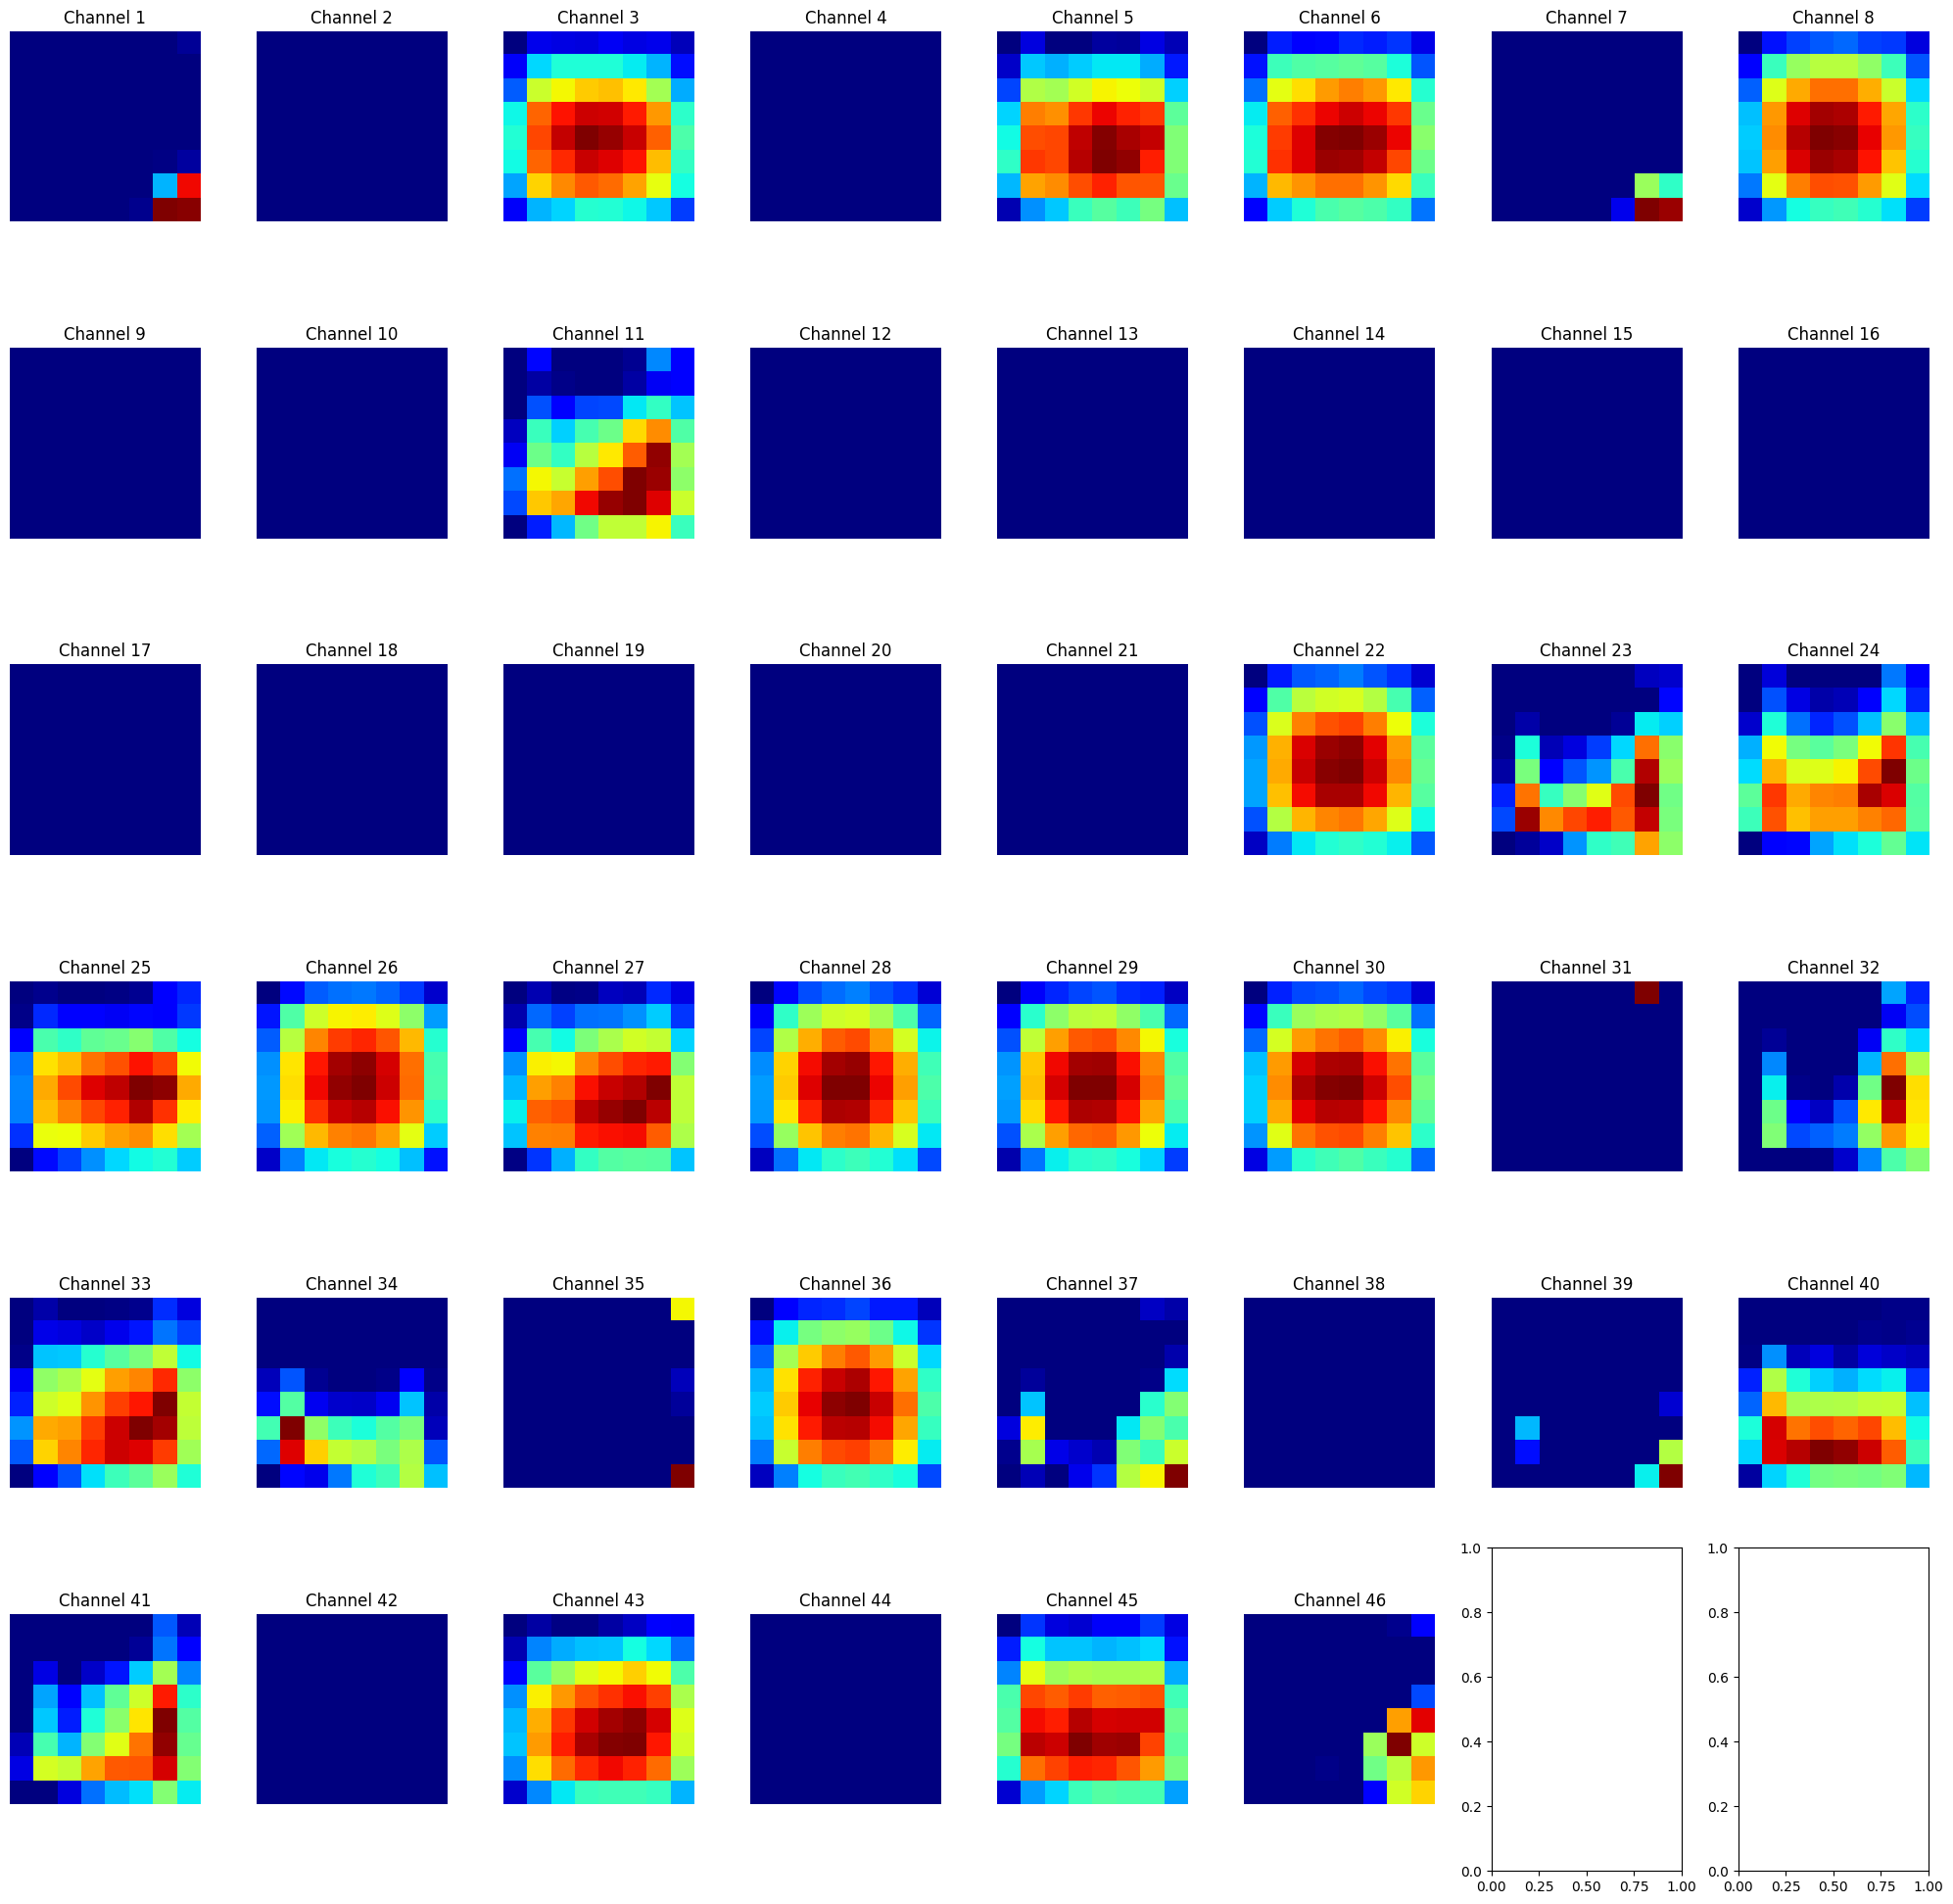

In [14]:
def plot_all_heatmaps(heatmaps):
    """
    Plot all heatmaps in a grid of subplots.

    Args:
    - heatmaps: List of heatmaps (each heatmap is a 2D array)
    """
    # Create a grid of subplots (e.g., 6 rows x 8 columns for 46 heatmaps)
    num_heatmaps = len(heatmaps)
    rows = 6  # Number of rows (adjust as needed)
    cols = 8  # Number of columns (adjust as needed)
    
    # Create a figure and set of subplots
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    axes = axes.flatten()  # Flatten the axes array for easier iteration
    
    # Plot each heatmap in a subplot
    for idx, heatmap in enumerate(heatmaps):
        ax = axes[idx]
        ax.imshow(heatmap, cmap='jet')
        ax.set_title(f"Channel {idx + 1}")
        ax.axis('off')  # Hide the axis
        # plt.colorbar(ax.imshow(heatmap, cmap='jet'), ax=ax, shrink = 2)  # Add color bar
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Example usage
plot_all_heatmaps(heatmaps2)  # Assuming 'heatmaps' is your list of heatmaps

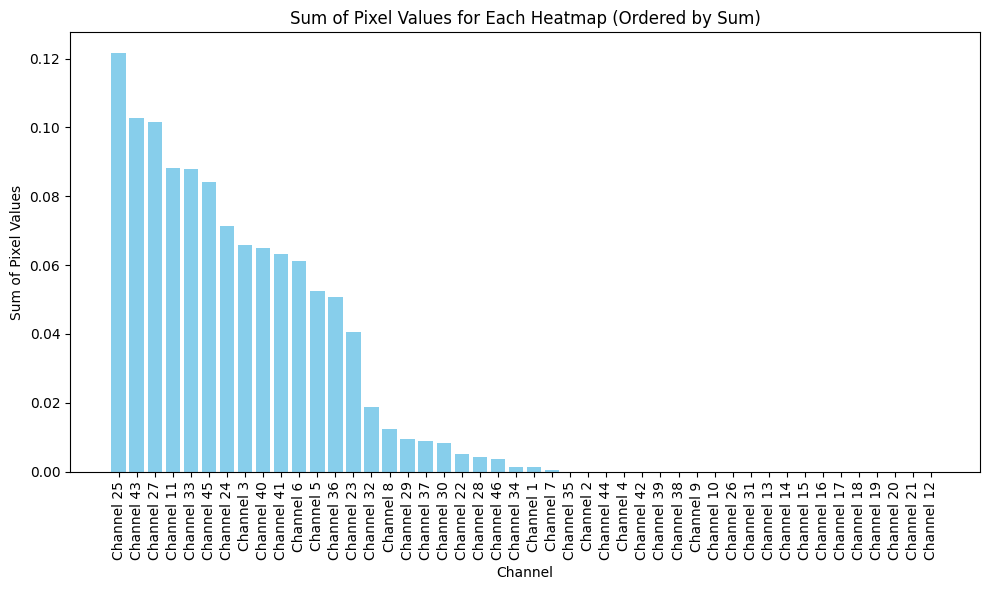

In [16]:
def plot_heatmap_sums(heatmaps):
    """
    Plot a bar chart that sums up pixel values for each heatmap and orders from highest to lowest.

    Args:
    - heatmaps: List of heatmaps (each heatmap is a 2D array)
    """
    # Sum up the pixel values for each heatmap (flatten the 2D heatmaps)
    heatmap_sums = [np.sum(heatmap) for heatmap in heatmaps]
    
    # Sort the sums from highest to lowest
    sorted_indices = np.argsort(heatmap_sums)[::-1]  # Sort in descending order
    sorted_sums = np.array(heatmap_sums)[sorted_indices]
    
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sorted_sums)), sorted_sums, color='skyblue')
    plt.xlabel('Channel')
    plt.ylabel('Sum of Pixel Values')
    plt.title('Sum of Pixel Values for Each Heatmap (Ordered by Sum)')
    plt.xticks(range(len(sorted_sums)), [f'Channel {i+1}' for i in sorted_indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Example usage
plot_heatmap_sums(heatmaps)  # Assuming 'heatmaps' is your list of heatmaps

In [13]:
last_conv_layer_name = model.layers[-9].name  # Replace with your model's target layer
target_output_index = 0  # Replace with the desired output index (e.g., class index)
num_channels = 46

In [48]:
np.min(images[5])

-2.371109042630728

In [8]:
import shap 
explainer = shap.KernelExplainer(model,X_test[0:2])

I0000 00:00:1734886025.860300 1036419 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-22 16:47:09.283270: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1193] failed to allocate 11.72GiB (12584037888 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-12-22 16:47:09.283382: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1193] failed to allocate 10.55GiB (11325634560 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-12-22 16:47:09.283452: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1193] failed to allocate 9.49GiB (10193071104 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-12-22 16:47:09.283519: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1193] failed to allocate 8.54GiB (9173764096 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-12-22 16:47:09.283585: I external/local_xla/

In [14]:
# Compute SHAP values for the input data X
single_image = np.expand_dims(X_test[3], axis = 0)
shap_values = explainer.shap_values(single_image)

DimensionError: Instance must have 1 or 2 dimensions!

In [20]:
img_array = np.expand_dims(img_array, axis = 0)

In [22]:
def make_gradcam_heatmap_all_channels(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model mapping the input image to the activations of the last conv layer and predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Get the number of channels in the input image
    num_channels = 46
    heatmaps = []
    
    for channel_idx in range(num_channels):
        # Process each channel separately
        channel_data = img_array[..., channel_idx:channel_idx + 1]
        
        # Compute gradient of the top predicted class for the channel
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(channel_data)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]
        
        # Compute gradients and pooled gradients
        grads = tape.gradient(class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        # Multiply activations by pooled gradients and compute heatmap
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        
        # Normalize heatmap between 0 and 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        heatmaps.append(heatmap.numpy())
    
    return heatmaps


def save_and_display_gradcam_all_channels(img_path, img_array, heatmaps, alpha=0.4):
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    num_channels = len(heatmaps)
    
    # Setup the grid for displaying results
    ncols = 6
    nrows = int(np.ceil(num_channels / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10))
    axs = axs.flatten()
    
    for i, heatmap in enumerate(heatmaps):
        # Rescale heatmap to range 0-255
        heatmap = np.uint8(255 * heatmap)
        
        # Apply jet colormap
        jet = mpl.colormaps["jet"]
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]
        
        # Resize heatmap and overlay on the corresponding channel of the image
        jet_heatmap = keras.utils.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.utils.img_to_array(jet_heatmap)
        
        channel_img = img[..., i % img.shape[-1]]  # Get the corresponding channel
        channel_img_rgb = np.stack([channel_img] * 3, axis=-1)  # Convert to RGB
        
        superimposed_img = jet_heatmap * alpha + channel_img_rgb
        superimposed_img = keras.utils.array_to_img(superimposed_img)
        
        # Display in subplot
        axs[i].imshow(superimposed_img)
        axs[i].set_title(f"Channel {i+1}")
        axs[i].axis("off")
    
    # Hide unused subplots
    for ax in axs[num_channels:]:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()


# Example usage
img_array = load_image(image_path)  # Replace with your image loading function
heatmaps = make_gradcam_heatmap_all_channels(img_array, model, last_conv_layer_name)
save_and_display_gradcam_all_channels(image_path, img_array, heatmaps)

ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input [[[0.01284193]
  [0.04459459]
  [0.11645827]
  ...
  [0.10525944]
  [0.07534455]
  [0.00505124]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 ...

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.00299698]
  [0.00485265]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.06687225]
  [0.09614045]
  ...
  [0.        ]
  [0.00414831]
  [0.40672734]]]. Expected shape (None, 224, 224, 46), but input has incompatible shape (46, 224, 1)[0m

Arguments received by Functional.call():
  • inputs=array([[[0.01284193],
        [0.04459459],
        [0.11645827],
        ...,
        [0.10525944],
        [0.07534455],
        [0.00505124]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.00299698],
        [0.00485265]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.06687225],
        [0.09614045],
        ...,
        [0.        ],
        [0.00414831],
        [0.40672734]]], dtype=float32)
  • training=None
  • mask=None

In [19]:
img_array.shape

(46, 224, 224)